In [1]:
import cv2
import random
import os
import keras
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout,
    Input,
    Activation,
    concatenate,
)

In [4]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "C:/Users/akshg/Desktop/asl_dataset/"

# Dictionary to save our 12 classes
categories = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "a",
    11: "b",
    12: "c",
    13: "d",
    14: "e",
    15: "f",
    16: "g",
    17: "h",
    18: "i",
    19: "j",
    20: "k",
    21: "l",
    22: "m",
    23: "n",
    24: "o",
    25: "p",
    26: "q",
    27: "r",
    28: "s",
    29: "t",
    30: "u",
    31: "v",
    32: "w",
    33: "x",
    34: "y",
    35: "z",
}

In [5]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print("number of elements = ", len(df))
df

number of elements =  2515


,filename,category
0,4/hand1_4_bot_seg_2_cropped.jpeg,4
1,n/hand1_n_right_seg_5_cropped.jpeg,23
2,0/hand5_0_bot_seg_5_cropped.jpeg,0
3,k/hand2_k_bot_seg_3_cropped.jpeg,20
4,p/hand2_p_left_seg_3_cropped.jpeg,25
...,...,...
2510,e/hand5_e_bot_seg_5_cropped.jpeg,14
2511,r/hand2_r_right_seg_5_cropped.jpeg,27
2512,p/hand2_p_dif_seg_1_cropped.jpeg,25
2513,3/hand1_3_right_seg_1_cropped.jpeg,3


t/hand4_t_bot_seg_5_cropped.jpeg


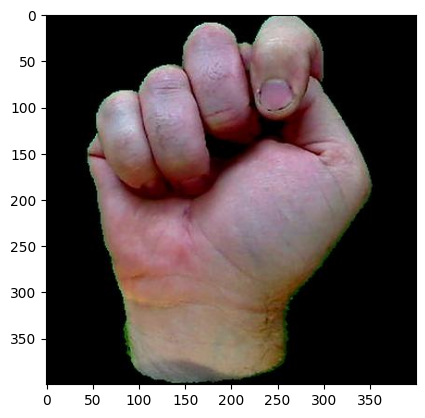

In [6]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(base_path + sample["filename"])
print(sample["filename"])
plt.imshow(randomimage)

Text(0.5, 1.02, 'Count of images per class')

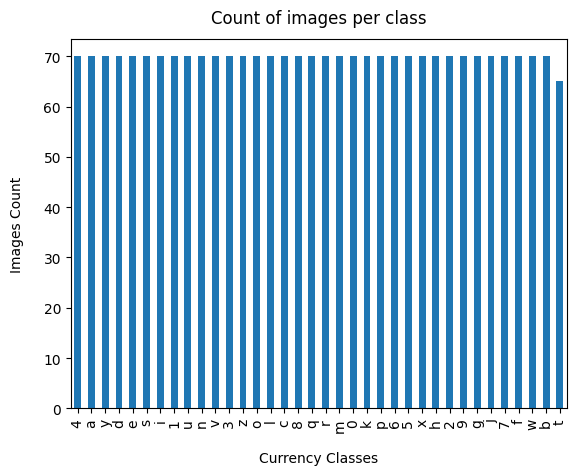

In [7]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization["category"] = df_visualization["category"].apply(
    lambda x: categories[x]
)

df_visualization["category"].value_counts().plot.bar(x="count", y="category")

plt.xlabel("Currency Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02)

In [8]:
# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.25, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
print(
    "train size =",
    total_train,
    "validate size =",
    total_validate,
    "test size =",
    test_df.shape[0],
)

train size = 1886 validate size = 314 test size = 315


In [9]:
batch_size = 32

datagen = image.ImageDataGenerator(
    ###  Augmentation Start  ###
    rescale=1.0 / 255,
    #     brightness_range=[0.5, 1.5],
    #     rotation_range=30,
    #     shear_range=0.1,
    #     zoom_range=0.3,
    #     horizontal_flip=True,
    #     vertical_flip = True,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2
    ##  Augmentation End  ###
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
)

Found 1886 validated image filenames belonging to 36 classes.
Found 314 validated image filenames belonging to 36 classes.
Found 315 validated image filenames belonging to 36 classes.


In [10]:
bnmomemtum = 0.9


def fire_module(x, squeeze, expand):
    y = Conv2D(filters=squeeze, kernel_size=1, activation="relu", padding="same")(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand // 2, kernel_size=1, activation="relu", padding="same")(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand // 2, kernel_size=3, activation="relu", padding="same")(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])


def SqueezeNet(input_shape, num_classes):
    input = Input(shape=input_shape)
    y = Conv2D(kernel_size=7, filters=96, strides=2, padding="same", activation="relu")(input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 32, 128)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 32, 128)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 64, 256)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(y, 64, 256)
    y = Conv2D(kernel_size=1, filters=1000, strides=1, padding="same", activation="relu")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(num_classes, activation="softmax")(y)
    model = Model(input, y)
    return model

In [11]:
model = SqueezeNet(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), num_classes=len(categories)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 96  14208       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 96  384        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# model = Sequential()
# model.add(
#     Conv2D(
#         filters=32,
#         kernel_size=7,
#         activation="relu",
#         padding="same",
#         input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
#     )
# )
# # model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
# # model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
# # model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# # model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
# # model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(4096, activation="relu"))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Dense(4096, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(len(categories), activation="softmax"))

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.summary()

In [14]:
EPOCHS = 5
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/5
58/58 [==============================] - 170s 3s/step - loss: 0.0717 - accuracy: 0.9757 - val_loss: 0.3838 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 2/5
58/58 [==============================] - 170s 3s/step - loss: 0.1046 - accuracy: 0.9639 - val_loss: 0.8131 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/5
58/58 [==============================] - 172s 3s/step - loss: 0.1219 - accuracy: 0.9612 - val_loss: 0.7092 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 4/5
58/58 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9520
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
58/58 [==============================] - 165s 3s/step - loss: 0.1457 - accuracy: 0.9520 - val_loss: 2.8866 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 5/5
58/58 [==============================] - 161s 3s/step - loss: 0.0512 - accuracy: 0.9860 - val_loss: 0.1032 - val_accuracy: 0.9653 - lr: 3.0000e-04


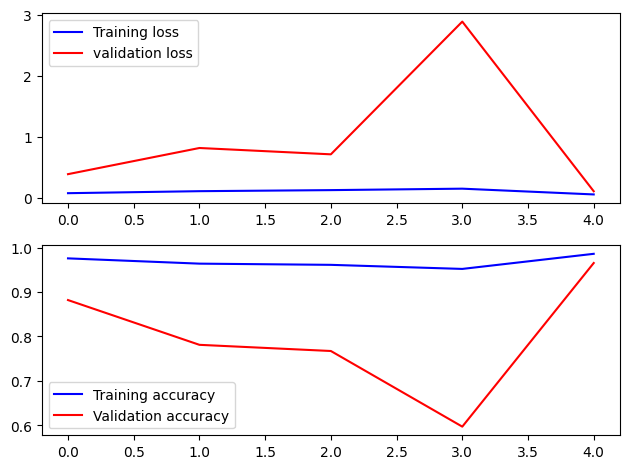

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history["loss"], color="b", label="Training loss")
ax1.plot(history.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)
print("Accuracy on test set = ", round((accuracy * 100), 2), "% ")

C:\Users\akshg\AppData\Local\Temp\ipykernel_16864\2202250694.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  94.92 % 


In [17]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


In [18]:
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df["category"].to_numpy()

print(classification_report(labels, preds))

315/315 [==============================] - 8s 23ms/step
              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.73      1.00      0.84         8
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         7
           4       0.90      1.00      0.95         9
           5       1.00      0.88      0.93         8
           6       0.94      0.94      0.94        16
           7       1.00      1.00      1.00         8
           8       0.91      1.00      0.95        10
           9       1.00      0.83      0.91         6
           a       1.00      1.00      1.00         4
           b       1.00      1.00      1.00         7
           c       1.00      1.00      1.00        13
           d       1.00      1.00      1.00         5
           e       1.00      1.00      1.00         9
           f       1.00      1.00      1.00        11
           g       1.00  

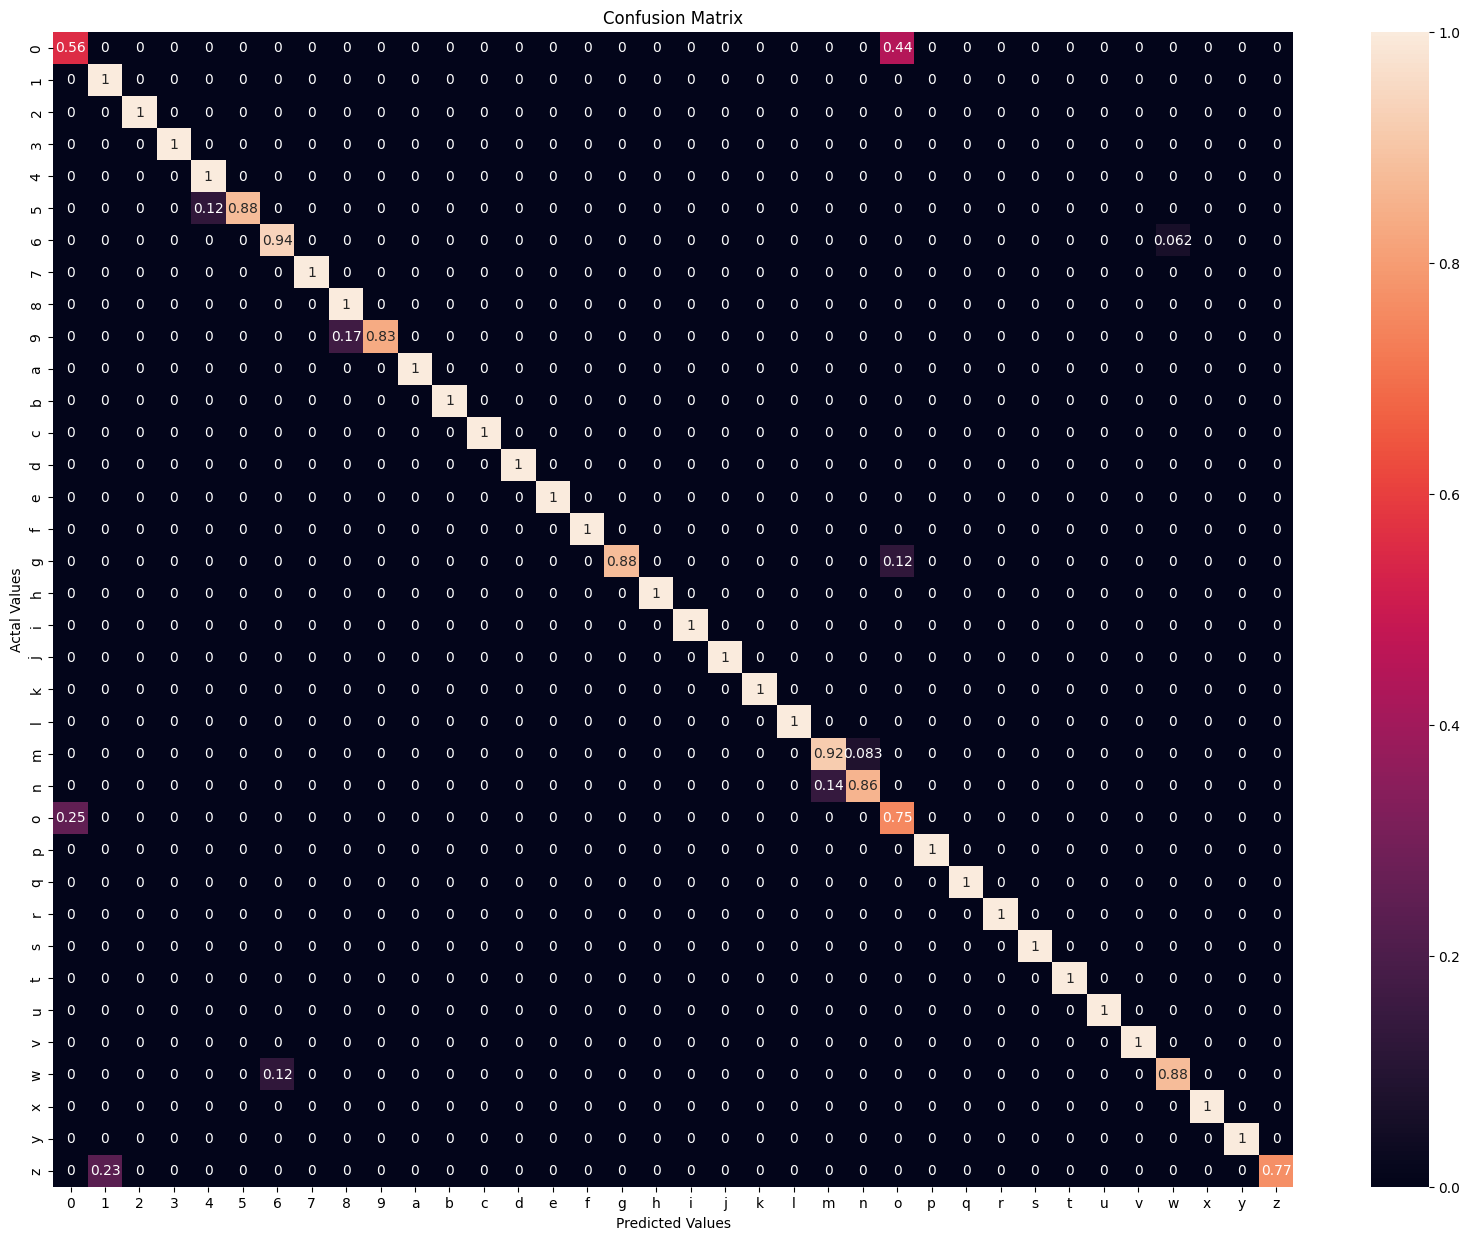

In [19]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize="true")
cm_df = pd.DataFrame(
    confusion_matrix, index=categories.values(), columns=categories.values()
)
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actal Values")
plt.xlabel("Predicted Values")
plt.show()